In [1]:

import pandas as pd
import numpy as np
import math
import ast
import sklearn


import seaborn as sns
import matplotlib.pyplot as plt
from matplotlib.patches import Patch


from tqdm import tqdm

In [18]:
data = pd.read_csv('/content/shots_data_2015_25.csv')


In [19]:
data = data[data['body_part'].isin(['Right Foot','Left Foot'])]

In [20]:
data.columns

Index(['Unnamed: 0', 'level_0', 'id', 'index', 'play_pattern', 'location',
       'shot', 'possession_team', 'type', 'outcome', 'body_part', 'players',
       'home_team', 'follows_dribble', 'teammates_in_box', 'teammates_ahead',
       'opp_in_box', 'gk_dist_from_goal', 'gk_dist_from_player', 'gk_x',
       'gk_y', 'opponents_near', 'x', 'y', 'distance', 'angle'],
      dtype='object')

In [21]:
data.drop(columns=['Unnamed: 0','level_0','id', 'index', 'play_pattern', 'location', 'shot', 'possession_team',
       'type', 'body_part', 'players',],inplace=True)

In [22]:
from sklearn.preprocessing import MinMaxScaler, OrdinalEncoder, OneHotEncoder

In [26]:
# test train split with 20% going to test set stratified on outcome
from sklearn.model_selection import train_test_split
X_train, X_test, y_train, y_test = train_test_split(data.drop(columns=['outcome']), data['outcome'], test_size=0.2, stratify=data['outcome'], random_state=42)


In [27]:
X_train.columns

Index(['home_team', 'follows_dribble', 'teammates_in_box', 'teammates_ahead',
       'opp_in_box', 'gk_dist_from_goal', 'gk_dist_from_player', 'gk_x',
       'gk_y', 'opponents_near', 'x', 'y', 'distance', 'angle'],
      dtype='object')

In [28]:
cont_features = [ 'gk_dist_from_goal', 'gk_dist_from_player','distance', 'angle']
ord_features = ['teammates_in_box', 'teammates_ahead', 'opp_in_box','opponents_near']
binary_features = ['home_team']
all_features = cont_features+ord_features+binary_features

## Baseline Logistic regression Model

In [52]:
features_to_use = ['distance','angle']

# Select only the features to use
X_train_selected = X_train[features_to_use]
X_test_selected = X_test[features_to_use]


import statsmodels.api as sm

logit_model = sm.Logit(y_train, sm.add_constant(X_train_selected))
result = logit_model.fit()
print("\nLogistic Regression Summary (using statsmodels):")
print(result.summary())

Optimization terminated successfully.
         Current function value: 0.266632
         Iterations 8

Logistic Regression Summary (using statsmodels):
                           Logit Regression Results                           
Dep. Variable:                outcome   No. Observations:                15350
Model:                          Logit   Df Residuals:                    15347
Method:                           MLE   Df Model:                            2
Date:                Sat, 09 Aug 2025   Pseudo R-squ.:                  0.1688
Time:                        12:44:16   Log-Likelihood:                -4092.8
converged:                       True   LL-Null:                       -4923.8
Covariance Type:            nonrobust   LLR p-value:                     0.000
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const         -0.8478      0.180     -4.716      0.000    

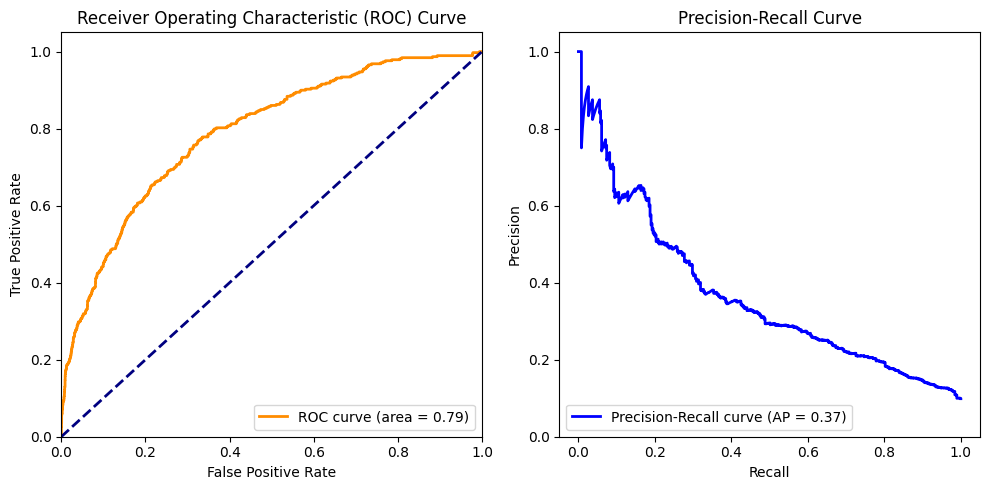

In [53]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import statsmodels.api as sm

# Get probability predictions for the positive class (class 1) using statsmodels result
# Need to add constant to the test set features as well
y_prob = result.predict(sm.add_constant(X_test_selected))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test, y_prob)
average_precision = average_precision_score(y_test, y_prob)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0.0, 1.05])
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

### Using just distance and angle, we already have a pretty good model

In [59]:
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score, classification_report
import numpy as np
import statsmodels.api as sm # Import statsmodels to use sm.add_constant

# Ensure X_test_selected has all the features used for the statsmodels fit
# (assuming result was trained on X_train_cleaned which had all features)
# We need to add a constant to the test features for prediction with statsmodels
X_test_selected_with_const = sm.add_constant(X_test_selected[features_to_use], has_constant='add')


# Make predictions on the test set using the statsmodels result
# statsmodels predict returns probabilities by default, so we need to threshold them
y_prob_statsmodels = result.predict(X_test_selected_with_const)
y_pred_statsmodels = (y_prob_statsmodels > 0.4).astype(int)

# Calculate basic classification metrics for the statsmodels model
accuracy_sm = accuracy_score(y_test, y_pred_statsmodels)
precision_sm = precision_score(y_test, y_pred_statsmodels)
recall_sm = recall_score(y_test, y_pred_statsmodels)
f1_sm = f1_score(y_test, y_pred_statsmodels)

print("Metrics for Statsmodels Logistic Regression (all features):")
print(f"Accuracy: {accuracy_sm:.4f}")
print(f"Precision: {precision_sm:.4f}")
print(f"Recall: {recall_sm:.4f}")
print(f"F1-score: {f1_sm:.4f}")


# Provide a detailed classification report for the statsmodels model
print("\nClassification Report for Statsmodels Logistic Regression (all features):")
print(classification_report(y_test, y_pred_statsmodels))


Metrics for Statsmodels Logistic Regression (all features):
Accuracy: 0.9052
Precision: 0.5581
Recall: 0.1900
F1-score: 0.2835

Classification Report for Statsmodels Logistic Regression (all features):
              precision    recall  f1-score   support

           0       0.92      0.98      0.95      3459
           1       0.56      0.19      0.28       379

    accuracy                           0.91      3838
   macro avg       0.74      0.59      0.62      3838
weighted avg       0.88      0.91      0.88      3838



### Logistic regression model with all the features

In [60]:
X_train_selected = X_train[all_features]
X_test_selected = X_test[all_features]

# Check for and handle missing values
print("Checking for missing values in X_train_selected before handling:")
print(X_train_selected.isnull().sum())
print("\nChecking for infinite values in X_train_selected before handling:")
print(np.isinf(X_train_selected).sum())

# Combine X_train_selected and y_train to easily drop rows with missing values
train_data_combined = pd.concat([X_train_selected, y_train.rename('outcome')], axis=1)

# Drop rows with NaN or Inf values
train_data_cleaned = train_data_combined.replace([np.inf, -np.inf], np.nan).dropna()

# Separate features and target again
X_train_cleaned = train_data_cleaned.drop(columns=['outcome'])
y_train_cleaned = train_data_cleaned['outcome']

print("\nShape of X_train_selected after dropping missing values:", X_train_cleaned.shape)
print("Shape of y_train after dropping missing values:", y_train_cleaned.shape)


import statsmodels.api as sm

# Fit the logistic regression model on the cleaned data
logit_model = sm.Logit(y_train_cleaned, sm.add_constant(X_train_cleaned))
result = logit_model.fit()
print("\nLogistic Regression Summary (using statsmodels):")
print(result.summary())

Checking for missing values in X_train_selected before handling:
gk_dist_from_goal      10
gk_dist_from_player    10
distance                0
angle                   0
teammates_in_box        0
teammates_ahead         0
opp_in_box              0
opponents_near          0
home_team               0
dtype: int64

Checking for infinite values in X_train_selected before handling:
gk_dist_from_goal      0
gk_dist_from_player    0
distance               0
angle                  0
teammates_in_box       0
teammates_ahead        0
opp_in_box             0
opponents_near         0
home_team              0
dtype: int64

Shape of X_train_selected after dropping missing values: (15340, 9)
Shape of y_train after dropping missing values: (15340,)
Optimization terminated successfully.
         Current function value: 0.257639
         Iterations 8

Logistic Regression Summary (using statsmodels):
                           Logit Regression Results                           
Dep. Variable:            

### gk_dist_from_goal, gk_dist_from_player, distance, angle are the strongest features

### teammates_ahead, opponents_near and home_team are not significant features in modelling

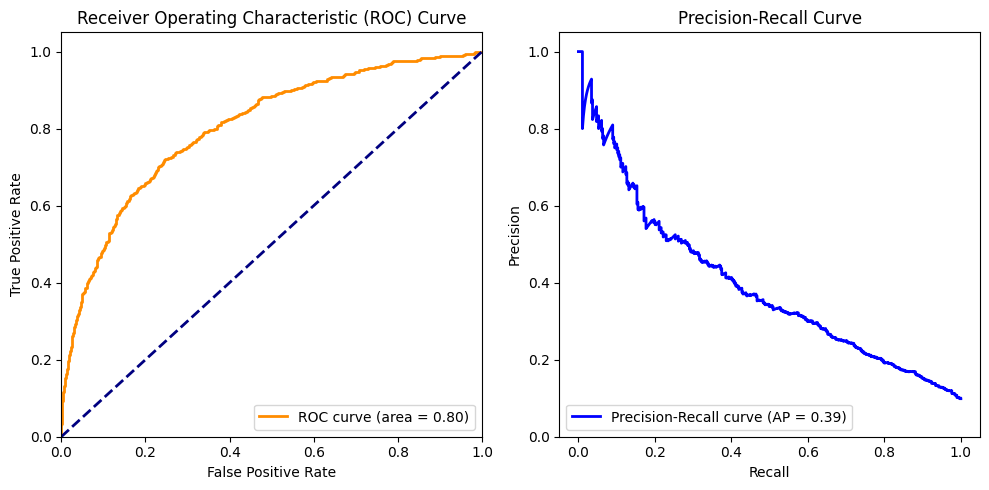

In [61]:
from sklearn.metrics import roc_curve, auc, precision_recall_curve, average_precision_score
import matplotlib.pyplot as plt
import statsmodels.api as sm
import numpy as np

# Combine X_test_selected and y_test to easily drop rows with missing values
test_data_combined = pd.concat([X_test_selected, y_test.rename('outcome')], axis=1)

# Drop rows with NaN or Inf values from the test set
test_data_cleaned = test_data_combined.replace([np.inf, -np.inf], np.nan).dropna()

# Separate features and target again for the cleaned test set
X_test_cleaned = test_data_cleaned.drop(columns=['outcome'])
y_test_cleaned = test_data_cleaned['outcome']


# Get probability predictions for the positive class (class 1) using statsmodels result
# Need to add constant to the cleaned test set features
y_prob = result.predict(sm.add_constant(X_test_cleaned))

# Plot ROC Curve
fpr, tpr, thresholds = roc_curve(y_test_cleaned, y_prob)
roc_auc = auc(fpr, tpr)

plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.plot(fpr, tpr, color='darkorange', lw=2, label=f'ROC curve (area = {roc_auc:.2f})')
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver Operating Characteristic (ROC) Curve')
plt.legend(loc="lower right")

# Plot Precision-Recall Curve
precision, recall, _ = precision_recall_curve(y_test_cleaned, y_prob)
average_precision = average_precision_score(y_test_cleaned, y_prob)

plt.subplot(1, 2, 2)
plt.plot(recall, precision, color='blue', lw=2, label=f'Precision-Recall curve (AP = {average_precision:.2f})')
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.title('Precision-Recall Curve')
plt.ylim([0.0, 1.05])
plt.legend(loc="lower left")

plt.tight_layout()
plt.show()

### Having a high AUC of ROC indicates the ability to separate the two classes through modelling

### Average Precision is more important for our case since we have a highly imbalanced dataset

In [68]:

# Make predictions on the test set using the statsmodels result
# statsmodels predict returns probabilities by default, so we need to threshold them
y_prob_statsmodels = result.predict(sm.add_constant(X_test_cleaned))
y_pred_statsmodels = (y_prob_statsmodels > 0.5).astype(int)

# Calculate basic classification metrics for the statsmodels model
accuracy_sm = accuracy_score(y_test_cleaned, y_pred_statsmodels)
precision_sm = precision_score(y_test_cleaned, y_pred_statsmodels)
recall_sm = recall_score(y_test_cleaned, y_pred_statsmodels)
f1_sm = f1_score(y_test_cleaned, y_pred_statsmodels)

print("Metrics for Statsmodels Logistic Regression (all features):")
print(f"Accuracy: {accuracy_sm:.4f}")
print(f"Precision: {precision_sm:.4f}")
print(f"Recall: {recall_sm:.4f}")
print(f"F1-score: {f1_sm:.4f}")


# Provide a detailed classification report for the statsmodels model
print("\nClassification Report for Statsmodels Logistic Regression (all features):")
print(classification_report(y_test_cleaned, y_pred_statsmodels))


Metrics for Statsmodels Logistic Regression (all features):
Accuracy: 0.9070
Precision: 0.6170
Recall: 0.1530
F1-score: 0.2452

Classification Report for Statsmodels Logistic Regression (all features):
              precision    recall  f1-score   support

           0       0.91      0.99      0.95      3458
           1       0.62      0.15      0.25       379

    accuracy                           0.91      3837
   macro avg       0.77      0.57      0.60      3837
weighted avg       0.88      0.91      0.88      3837

